In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import confseq
from confseq.conjmix_bounded import *
import multiprocess as mp
from tqdm.notebook import tqdm

In [2]:
from scipy.special import expit

In [3]:
def gen_logit_data(X=None, beta=None, beta_norm=3, var=1, n=1000, d=10, seed=None):
    rng = np.random.default_rng(seed=seed)
    if X is None:
        X = rng.normal(size=(n, d))
    if beta is None:
        beta = rng.normal(size=(d + 1))
        beta = beta / np.linalg.norm(beta) * beta_norm
    coef, bias = beta[:(-1)], beta[-1]
    Y = rng.binomial(1, expit(X.dot(coef) + bias))
    return Y, X, coef, bias

In [4]:
seed = 322
d = 10
train_n = 100
train_Y, train_X, true_coef, true_bias = gen_logit_data(n=100, d=10, seed=seed)
print(true_coef, true_bias)

[ 0.98297473 -1.90200438 -0.34104811  0.58016974 -1.0934589  -0.38466286
  1.13143942 -0.20046086  0.96767645 -0.0155843 ] -0.6021885901714426


(Text(0.5, 0, '$X_1$'), Text(0, 0.5, '$X_2$'))

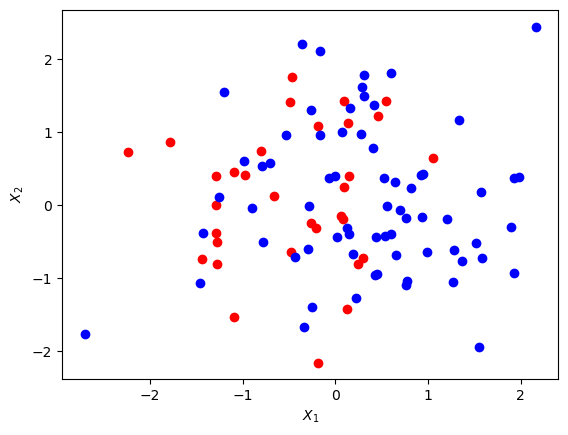

In [5]:
fig, ax = plt.figure(), plt.gca()
ax.scatter(train_X[train_Y == 1, 1], train_X[train_Y == 1, 2], color='red', label='1')
ax.scatter(train_X[train_Y == 0, 1], train_X[train_Y == 0, 2], color='blue', label='0')
ax.set_xlabel('$X_1$'), ax.set_ylabel('$X_2$')

In [6]:
import sklearn
import sklearn.linear_model as sklm

In [7]:
learned_model = sklm.LogisticRegression(penalty=None, random_state=seed)
learned_model.fit(train_X, train_Y)

LogisticRegression(penalty=None, random_state=322)

In [8]:
test_n=10000

In [9]:
test_Y, test_X, _, _ = gen_logit_data(beta=np.concatenate([true_coef, np.array(true_bias).reshape(-1)]), n=test_n, seed=seed + 1)

In [10]:
print(np.sum(test_Y) / len(test_Y))

0.4393


In [11]:
learned_prob = learned_model.predict_proba(test_X)

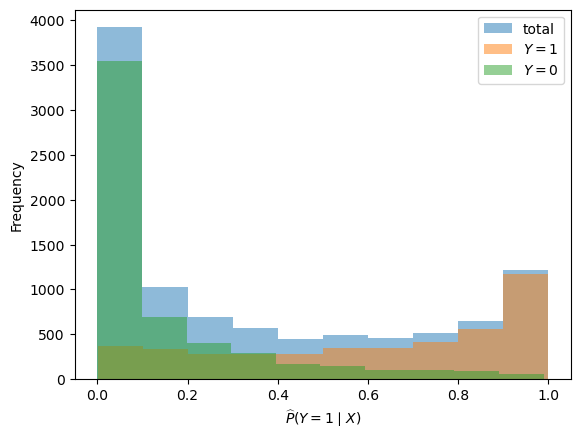

In [12]:
fig, ax = plt.figure(), plt.gca()
ax.hist(learned_prob[:, 1], label='total', alpha=0.5)
ax.hist(learned_prob[test_Y == 1, 1], label='$Y = 1$', alpha=0.5)
ax.hist(learned_prob[test_Y == 0, 1], label='$Y = 0$', alpha=0.5)
ax.set_xlabel('$\widehat{P}(Y = 1 \mid X)$'), ax.set_ylabel('Frequency')
ax.legend()

In [13]:
mc_Y, mc_X, _, _ = gen_logit_data(beta=np.concatenate([true_coef, np.array(true_bias).reshape(-1)]), n=100000, seed=seed + 2)
mc_probs = learned_model.predict_proba(mc_X)

In [14]:
import scipy
import scipy.optimize

(Text(0.5, 0, '$\\beta$'),
 Text(0, 0.5, 'FP'),
 Text(0.5, 1.0, 'Smallest $\\beta$ with FP($\\beta$) $\\leq$ $\\theta$ is 0.502'))

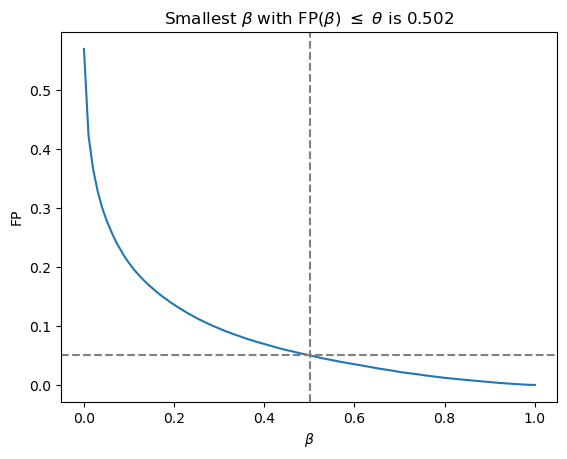

In [15]:
def calc_fp(beta):
    return np.mean((mc_probs[:, 1] > beta).astype(int) * (1 - mc_Y).astype(int))

theta = 0.05
sol = scipy.optimize.root_scalar(lambda beta: calc_fp(beta) - theta, x0=0.5, bracket=(0., 1.))

fig, ax = plt.figure(), plt.gca()
beta_choices = np.linspace(0, 1, 100)
ax.plot(beta_choices, [calc_fp(beta) for beta in beta_choices])
ax.axhline(0.05, color='gray', linestyle='dashed')
ax.axvline(sol.root, color='gray', linestyle='dashed')
ax.set_xlabel('$\\beta$'), ax.set_ylabel('FP'), ax.set_title(f'Smallest $\\beta$ with FP($\\beta$) $\\leq$ $\\theta$ is {sol.root:.3f}')

# Martingale for standard case

In [16]:
def binary_fp_mart_fn(x, beta, **kwargs):
    """Martingale where we let l(X, Y, beta) be the empirical false positive indicator for binary classification.
    
    1 is positive. 0 is negative.
    
    :x: tuple of class probabilities and true class labels
    :beta: parameter in [0, 1]
    :theta: risk control parameter in [0, 1]"""
    fit_prob, Y, theta = x.T
    return confseq.betting.betting_mart(1 * (fit_prob > beta).astype(float) * (1 - Y).astype(float), 1 * theta[0], **kwargs)

def binary_fp_cs(fit_prob, Y, theta, alpha, **kwargs):
    x = np.array([fit_prob, Y, np.full(fit_prob.shape, theta)]).T
    return confseq.betting.cs_from_martingale(x, binary_fp_mart_fn, alpha=alpha, **kwargs)

In [17]:
class UpperMartingale:
    def __init__(self, *, rho, rho_max, theta, beta_min, beta_max, delta_beta, alpha):
        from collections import defaultdict
        from math import log
    
        assert rho_max > 0
        assert 0 <= theta <= rho_max
        assert beta_min < beta_max
        assert delta_beta > 0
        assert 0 < alpha < 1
        
        self.rho = rho
        self.rho_max = rho_max
        self.theta = theta
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.delta_beta = delta_beta
        self.alpha = alpha
        
        self.stats = defaultdict(lambda: [0, 0, 0])
        self.curlam = 0
        self.phicurlam = self._phi(self.curlam)
        self.maxlam = 1/(2*rho_max)
        self.curbeta = beta_max
        self.thres = -log(alpha)
        self._updatecurbetatest(max(beta_max - delta_beta, beta_min))
        self.betaminlogwealth = 0
        
    def addobs(self, x):
        self.stats[x][0] += 1
        self.stats[x][1] += self.curlam
        self.stats[x][2] += self.phicurlam
        
        ximin = self.theta - self.rho(x, self.beta_min)
        self.betaminlogwealth += self.curlam * ximin - self.phicurlam * ximin**2
        
        xitest = self.theta - self.rho(x, self.curbetatest)
        self.curbetatestlogwealth += self.curlam * xitest - self.phicurlam * xitest**2
        self.curbetatestnum += xitest
        self.curbetatestdenom += xitest**2
        
        if self.curbetatestnum <= 0:
            self.curlam = 0
        elif self.curbetatestnum <= self.maxlam * (self.curbetatestnum + self.curbetatestdenom):
            self.curlam = self.curbetatestnum / (self.curbetatestnum + self.curbetatestdenom)
        else:
            self.curlam = self.maxlam
            
        self.phicurlam = self._phi(self.curlam)

    def getbeta(self):
        if self.curbetatestlogwealth > self.thres:
            self._updatecs()
        return self.curbeta
    
    def _phi(self, x):
        from math import log1p
        return -x - log1p(-x)
        
    def _updatecurbetatest(self, beta):
        logw, num, denom = 0, 0, 0
        for x, stats in self.stats.items():
            xi = self.theta - self.rho(x, beta)
            logw += stats[1] * xi - stats[2] * xi**2
            num += stats[0] * xi
            denom += stats[0] * xi**2
            
        self.curbetatest = beta
        self.curbetatestlogwealth = logw
        self.curbetatestnum = num
        self.curbetatestdenom = denom       
    
    def _updatecs(self):
        from scipy import optimize as so
        if self.curbetatest <= self.beta_min:
            return
        
        maxbeta = self.curbetatest
        maxbetawealth = self.curbetatestlogwealth
        if maxbetawealth < self.thres:
            return
                
        minbeta = self.beta_min
        minbetawealth = self.betaminlogwealth
        if minbetawealth >= self.thres:
            self.curbeta = self.beta_min
            self._updatecurbetatest(self.beta_min)
            return
        
        def logwealth(beta):
            logw = 0
            for x, stats in self.stats.items():
                xi = self.theta - self.rho(x, beta)
                logw += stats[1] * xi - stats[2] * xi**2
                
            return logw
                        
        res = so.root_scalar(
            f = lambda beta: logwealth(beta)-self.thres, 
            xtol = self.delta_beta/10,
            method = 'brentq',
            bracket = [ minbeta, maxbeta ])
        assert res.converged, res
        self.curbeta = res.root
        self._updatecurbetatest(max(self.curbeta - self.delta_beta, self.beta_min))

        
def upper_mart_cs(fit_prob, Y, theta, alpha):
    def rho(x, beta):
        p, Y = x
        return (p >= beta) * (1 - Y)
    
    cs = UpperMartingale(rho=rho, rho_max=1, theta=theta, beta_min=0, beta_max=1, delta_beta=1e-3, alpha=alpha)
        
    rv = []
    for p, Y in zip(fit_prob, Y):
        cs.addobs((p, Y))
        rv.append(cs.getbeta())
    return rv
    
    
def test_once(gen, n_max):
    # p is the true probability of a positive 
    # our decision is 1_{beta <= p}
    # if beta > p we say negative so no risk
    # if beta <= p then we have a false positive with probability (1 - p)
    
    def rho(p, beta):
        return 0 if beta > p else (1 - p)
    
    cs = UpperMartingale(rho=rho, rho_max=1, theta=0.05, beta_min=0, beta_max=1, delta_beta=1e-3, alpha=0.05)
        
    rv = []
        
    for n in range(n_max):
        p = round(gen.uniform(), 2)
        cs.addobs(p)
        rv.append(cs.getbeta())
        
    print(cs.curbeta, cs.curbetatestlogwealth, cs.thres)

    return rv
        
def test():
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 4)
    
    gen = np.random.default_rng(1)
    curve = test_once(gen, 5000)
    ax1.plot(curve, label='beta')
    ax1.title.set_text('beta')
    
    truefp = lambda z: (100 - int(z)) * (101 - int(z)) / 20_000
    ax2.plot([ truefp(100*beta) for beta in curve ], label='truefp')
    ax2.plot([ 0.05 for beta in curve ], linestyle='dashed')
    ax2.title.set_text('false positive rate')
    
# test()

In [18]:
# cs_test = binary_fp_cs(learned_prob[:, 1], test_Y, theta=0.05, alpha=0.05 * 2)

In [19]:
# um_cs_test = upper_mart_cs(learned_prob[:, 1], test_Y, theta=0.05, alpha=0.05 * 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


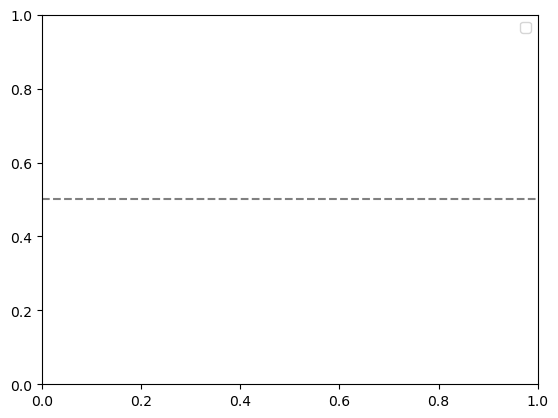

In [20]:
fig, ax = plt.figure(), plt.gca()
# ax.plot(np.arange(len(cs_test[1])), cs_test[1], label='empirical-Bernstein lambda')
# ax.plot(np.arange(len(cs_test[1])), um_cs_test, label='upper martingale')
ax.axhline(sol.root, color='gray', linestyle='dashed')
ax.legend()

# Active labeled martingale

In [21]:
def active_binary_fp_mart_fn(x, beta, alpha, q_max, **kwargs):
    """Martingale where we let l(X, Y, beta) be the empirical false positive indicator for binary classification.
    
    1 is positive. 0 is negative.
    
    :x: tuple of class probabilities and true class labels
    :beta: parameter in [0, 1]
    :theta: risk control parameter in [0, 1]"""
    fit_prob, Y, q, ind, theta = x.T
    r = (fit_prob > beta).astype(float) * (1 - Y).astype(float) # bounded between 0 and 1
    ipw_outcomes = (ind / q) * r
    # print(ipw_outcomes[:10])
    lams = confseq.betting_strategies.lambda_predmix_eb(ipw_outcomes, truncation=q_max, alpha=alpha)
    diffs = theta[0] - ipw_outcomes # theta also bounded between 0 and 1
    
    mart = np.cumprod(1 + lams * diffs)
    
    return mart

def active_binary_fp_cs(fit_prob, Y, q, ind, theta, alpha, q_max, **kwargs):
    x = np.array([fit_prob, Y, q, ind, np.full(fit_prob.shape, theta)]).T
    return confseq.betting.cs_from_martingale(x, lambda x, m: active_binary_fp_mart_fn(x, m, alpha=alpha, q_max=q_max), \
                                              alpha=alpha, **kwargs)

def rand_policy(fit_prob, Y, theta, alpha, budget: float, seed=None):
    q = np.full(fit_prob.shape, budget)
    rng = np.random.default_rng(seed)
    return q, rng.binomial(1, q)



def reward_fn(r, q, ind, theta, lam):
    return np.log(1 + lam * (theta - (ind * r / q)))

import torch


def lagrange_loss(q, gamma, B, theta, reward): 
    return torch.log(1 + lam * (theta - reward)) + gamma * (q - B)
"""
def make_reward( 


def label_policy_cs(X, Y, ell, theta, alpha, budget, seed=None):
    
    gamma = torch.autograd.Variable()
    q = torch.autograd.Variable()
    
    # for i, (x, y) in enumerate(zip(X, Y)):
"""

'\ndef make_reward( \n\n\ndef label_policy_cs(X, Y, ell, theta, alpha, budget, seed=None):\n    \n    gamma = torch.autograd.Variable()\n    q = torch.autograd.Variable()\n    \n    # for i, (x, y) in enumerate(zip(X, Y)):\n'

In [22]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F


## Policy classes

In [47]:
class Policy:
    def get_q_var(self, x):
        pass
    def get_feedback(self, y, **kwargs):
        pass
    
    def set_dual_max(self, dual_max):
        pass

class BaseRatePolicy(Policy):
    def __init__(self, q: float):
        super(BaseRatePolicy, self).__init__()
        self.q = torch.nn.init.constant_(torch.empty(1), q)
    def get_q_var(self, x):
        return self.q
    
def step_optimizer(loss, optimizer, **kwargs):
    loss.backward(**kwargs)
    optimizer.step()
    optimizer.zero_grad()

def bin_features(x, coef, bias, score_fn=None, beta=None, d=10):
    p = expit(x.dot(coef) + bias)
    if score_fn is not None and beta is not None:
        p = p * (score_fn(x) > beta)
    one_hots = np.zeros(shape=(x.shape[0], d))
    one_hots[np.arange(x.shape[0]), np.floor(p * d).astype(int)] = 1.
    assert np.all(np.sum(one_hots, axis=1) == 1.)
    return one_hots

class LogReg(torch.nn.Module):
    def __init__(self, d, featurizer=lambda x: x):
        super(LogReg, self).__init__()
        self.featurizer = featurizer
        self.beta = torch.nn.Linear(d, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.beta(torch.tensor(self.featurizer(x)).float()))
    
class DiffPolicy(Policy):
    def __init__(self, predictor_model, optimizer_fn, budget, q_min, dual_mode='best_response', \
                 dual_optimizer_fn=None, dual_max=None):
        assert dual_mode == 'best_response' and dual_max is not None or dual_optimizer_fn is not None
        
        self.predictor_model = predictor_model
        self.q_min = q_min
        self.optimizer = optimizer_fn(predictor_model.parameters())
        self.dual_v_hist = []
        self.dual_mode = dual_mode
        self.dual_v = torch.tensor(0., requires_grad=True)
        if dual_optimizer_fn is not None:
            self.dual_optimizer = dual_optimizer_fn([self.dual_v])
        self.dual_max = dual_max
        self.budget = budget
        
    def set_dual_max(self, dual_max):
        self.dual_max = dual_max
        
    def get_q_var(self, x):
        return self.q_min + (1 - self.q_min) * self.predictor_model.forward(x)
    
    def get_feedback(self, util, x=None, q_var=None):
        if q_var is None:
            q_var = self.get_q_var(x.reshape(1, -1))    
        
        if self.dual_mode == 'best_response':
            self.dual_v.data = torch.tensor(self.dual_max) if q_var.data > self.budget else torch.tensor(0.)
        else:
            dual_loss = self.dual_v * (self.budget - q_var)
            if self.dual_mode == 'be_the_leader':
                dual_loss.backward(retain_graph=True)
                self.dual_optimizer.step()
                self.dual_optimizer.zero_grad()
                self.dual_v.data.clamp_(0)

        self.dual_v_hist.append(self.dual_v.data.item())
        
        primal_loss = -util + self.dual_v * q_var
        primal_loss.backward()
        
        self.optimizer.step()
        
        self.optimizer.zero_grad()
        
    

## Iterative Active Martingale implementation

In [48]:
class ActiveUpperMartingale:
    def __init__(self, *, rho, rho_max, q_min, theta, beta_min, beta_max, delta_beta, budget, model, alpha):
        from collections import defaultdict
        from math import log
    
        assert rho_max > 0
        assert 0 <= theta <= rho_max
        assert beta_min <= beta_max
        assert delta_beta > 0
        assert 0 < alpha < 1
        
        self.rho = lambda x, y, beta: 0 if y is None else rho(x, y, beta)
        self.rho_max = rho_max
        self.theta = theta
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.delta_beta = delta_beta
        self.alpha = alpha
        self.q_min = q_min
        
        self.stats = defaultdict(lambda: [0, 0, 0])
        self.curlam = 0
        self.phicurlam = self._phi(self.curlam)
        self.maxlam = q_min/(2*rho_max)
        self.curbeta = beta_max
        self.thres = -log(alpha)
        self._updatecurbetatest(max(beta_max - delta_beta, beta_min))
        self.betaminlogwealth = 0
        self.dual_max = (self.maxlam * self.rho_max + self.maxlam * (self.rho_max / self.q_min) + \
                        self._phi(self.maxlam) * np.square(self.rho_max * (1 - 1 / self.q_min))) / budget
        
        self.model = model
        self.model.set_dual_max(self.dual_max)
        
        
    def _log_wealth(self, lam, phi_lam, diff_var: torch.autograd.Variable):
        return lam * diff_var - phi_lam * torch.square(diff_var)
    
    def addobs(self, score, y, x=None, q=None):
        """add observation
        :param score: score (i.e., 1d param) we're trying to calibrate
        :param x: covariate
        :param q: probability of labeling this point
        :param y: true label - None if we didn't get it
        """
        assert q is None or q >= self.q_min
                
        
        
        
        if q is None:
            risk = self.rho(score, y, self.curbetatest)
            q_var = self.model.get_q_var(x.reshape(1, -1))
            diff_var = self.theta - risk / q_var
            log_wealth_var = self._log_wealth(self.curlam, self.phicurlam, diff_var)
            
            xitest = diff_var.data
            self.curbetatestlogwealth += log_wealth_var.data
            
            min_diff_var = self.theta - self.rho(score, y, self.beta_min) / q_var
            min_log_wealth_var = self._log_wealth(self.curlam, self.phicurlam, min_diff_var)
            
            # ximin = (self.theta - self.rho(score, y, self.beta_min) / q_var).data
            self.betaminlogwealth += min_log_wealth_var.data
            # self.curlam * ximin - self.phicurlam * ximin**2
        
            # update the model w/ feedback
            # assert q_var.requires_grad
            penalty = 2 * (torch.log(1 - q_var if y is None else q_var)) * log_wealth_var.detach()
            # assert penalty.requires_grad
            util = log_wealth_var - penalty
            # util = log_wealth_var
            # util = -penalty
            # util = 0
            self.model.get_feedback(util, q_var=q_var)
            q = q_var.data.item()
        else:
            ximin = self.theta - self.rho(score, y, self.beta_min) / q
            self.betaminlogwealth += self.curlam * ximin - self.phicurlam * ximin**2
        
            
            xitest = self.theta - self.rho(score, y, self.curbetatest) / q
            self.curbetatestlogwealth += self.curlam * xitest - self.phicurlam * xitest**2
        
        self.stats[(score, y, q)][0] += 1
        self.stats[(score, y, q)][1] += self.curlam
        self.stats[(score, y, q)][2] += self.phicurlam
        
        
        self.curbetatestnum += xitest
        self.curbetatestdenom += xitest**2

        if self.curbetatestnum <= 0:
            self.curlam = 0
        elif self.curbetatestnum <= self.maxlam * (self.curbetatestnum + self.curbetatestdenom):
            self.curlam = self.curbetatestnum / (self.curbetatestnum + self.curbetatestdenom)
        else:
            self.curlam = self.maxlam

        self.phicurlam = self._phi(self.curlam)
    
    def getq(self, x):
        return self.model.get_q_var(x.reshape(1, -1)).item()
    
    def getbeta(self):
        if self.curbetatestlogwealth > self.thres:
            self._updatecs()
        return self.curbeta
    
    def _phi(self, x):
        from math import log1p
        return -x - log1p(-x)
        
    def _updatecurbetatest(self, beta):
        logw, num, denom = 0, 0, 0
        for (score, y, q), stats in self.stats.items():
            xi = self.theta - self.rho(score, y, beta) / q
            logw += stats[1] * xi - stats[2] * xi**2
            num += stats[0] * xi
            denom += stats[0] * xi**2
            
        self.curbetatest = beta
        self.curbetatestlogwealth = logw
        self.curbetatestnum = num
        self.curbetatestdenom = denom       
    
    def _updatecs(self):
        from scipy import optimize as so
        if self.curbetatest <= self.beta_min:
            return
        
        maxbeta = self.curbetatest
        maxbetawealth = self.curbetatestlogwealth
        if maxbetawealth < self.thres:
            return
                
        minbeta = self.beta_min
        minbetawealth = self.betaminlogwealth
        if minbetawealth >= self.thres:
            self.curbeta = self.beta_min
            self._updatecurbetatest(self.beta_min)
            return
        
        def logwealth(beta):
            logw = 0
            for (x, y, q), stats in self.stats.items():
                xi = self.theta - self.rho(x, y, beta) / q
                logw += stats[1] * xi - stats[2] * xi**2
                
            return logw
                        
        res = so.root_scalar(
            f = lambda beta: logwealth(beta)-self.thres, 
            xtol = self.delta_beta/10,
            method = 'brentq',
            bracket = [minbeta, maxbeta])
        assert res.converged, res
        self.curbeta = res.root
        self._updatecurbetatest(max(self.curbeta - self.delta_beta, self.beta_min))

def default_rho(score, y, beta):
    return (score >= beta) * (1 - y)
           
def active_upper_mart_cs(scores, ys, theta, alpha, budget, model, xs=None, rho=default_rho, q_min=1, beta_min=0, beta_max=1, seed=None):
    rng = np.random.default_rng(seed=seed)
    
    cs = ActiveUpperMartingale(rho=rho, rho_max=1, theta=theta, beta_min=beta_min, beta_max=beta_max, delta_beta=1e-3, q_min=q_min, \
                               alpha=alpha, budget=budget, model=model)
        
    rv = []
    qs = []
    did_labels = []
    
    if xs is None:
        xs = [np.array(score).reshape(1, 1) for score in scores]
    for x, score, y in zip(xs, scores, ys):
        # print(x, score, y)
        q = cs.getq(x)
        qs.append(q)
        did_label = rng.binomial(1, q)
        cs.addobs(score=score, x=x, y=y if did_label else None)
        did_labels.append(did_label)
        rv.append(cs.getbeta())
    return rv, qs, did_labels
    

## Modular version

In [49]:
from IwUpperMartingale import IwUpperMartingale
from OnlineMinimax import OnlineMinimax, BestResponse, BeTheLeader
from LogisticRegression import LogisticRegressor

In [50]:
class OnlineLogisticRegression(object):
    import torch

    def __init__(self, *, regressor, obj_fn, cons_fn, opt_fn):
        import torch

        super().__init__()

        self.regressor = regressor
        self.obj_fn = obj_fn
        self.cons_fn = cons_fn
        self.opt = opt_fn(self.regressor.parameters())
        
        # self.scheduler = sched_fn(self.opt)

    def predict(self, x):
        import torch
        feature, label = x
        pred = self.regressor(feature).squeeze(0)
        return pred, self.cons_fn(x, pred).item()

    def update(self, x, pred, dual):
        import torch

        self.opt.zero_grad()
        loss = -self.obj_fn(x, pred) + dual*self.cons_fn(x, pred)
        loss.mean().backward()

        self.opt.step()
        # self.scheduler.step()

class ActiveCS:
    def __init__(self, *, rho, theta, q_min, n_betas, alpha, omm, predictor, opt_fn, sched_fn, budget, seed):
        def active_rho(x, beta):
            feature, label = x
            return 0 if label is None else rho(x, beta)
        self.rng = np.random.default_rng(seed=seed)
        self.iwum = IwUpperMartingale(rho=active_rho, theta=theta, q_min=q_min, n_betas=n_betas, alpha=alpha)
        
        def obj_fn(x, pred):
            loss = active_rho(x, self.iwum.getbeta())
            wealth = torch.log1p(self.iwum.cur_lam * (theta - loss / pred))
            return -wealth.detach() * torch.log(pred) + wealth
        def cons_fn(x, pred):
            return budget - pred
        # primal_player, self.predictor = player_predictor_fn(obj_fn, cons_fn)
        self.predictor = predictor
        primal_player = OnlineLogisticRegression(regressor=self.predictor, \
                                                 obj_fn=obj_fn, cons_fn=cons_fn, opt_fn=opt_fn, sched_fn=sched_fn)
        
        self.omm = OnlineMinimax(primal_player, dual_player)
        self.betas = []
        self.qs = []
        self.did_labels = []
        
    def addobbs(self, feature, get_y_fn):
        q = self.predictor.predict(feature)
        x = (feature, get_y_fn()) if rng.binomial(1, q) else None
        self.iwum.addobs(x, q)
        self.omm.addobs(x)
        self.betas.append(self.iwum.getbeta())
        self.qs.append(q)
        self.did_labels.append(0 if x is None else 1)
    
    def process_obs(self, xs, ys):
        for x, y in zip(xs, ys):
            self.addobs(x, lambda: y)
        return self.betas, self.qs, self.did_labels
        

        


## Simulations

In [51]:
torch.use_deterministic_algorithms(True)

In [52]:
def debug_policy(name, q_min, qs, budget, dual_v_hist, \
                 best_bin_probs, model_bin_probs=None, avg_bin_probs=None, lr_model=None, optimal_weights=None):
    """Debugging function to plot the resulting labeling policy"""
    fig, axes=plt.subplots(nrows=4, ncols=1, figsize=(4, 8))
    
    print("How well did our online learner learn the correct probability weights?")
    if lr_model is not None:
        bin_probs = q_min + (1 - q_min) * expit(lr_model.beta.weight.data + lr_model.beta.bias.data).numpy().squeeze()
    else:
        bin_probs = model_bin_probs
    print('Probs under each bin', bin_probs)
    print('Approx correct probs', best_bin_probs)
    print(f'MAE: {np.mean(np.abs(bin_probs - best_bin_probs))}')
    axes[1].scatter(np.arange(len(best_bin_probs)), bin_probs, label='Predicted probs')
    if avg_bin_probs is not None:
        axes[1].scatter(np.arange(len(best_bin_probs)), avg_bin_probs, label='avg pred probs')

    axes[1].scatter(np.arange(len(best_bin_probs)), best_bin_probs, label='approx. oracle probs', color='gray', linestyle='dashed')
    axes[1].set_xlabel('Bin Index'), axes[1].set_ylabel('$q_t$ prediction')
    axes[1].axhline(budget, color='red')
    axes[1].axhline(q_min, color='blue')
    # axes[1].legend()


    
    axes[0].hist(qs)
    axes[0].set_xlim((0, 1))
    axes[0].set_xlabel('$q_t$ value'), ax.set_ylabel('Count')
    axes[0].axvline(budget, color='red'), axes[0].axvline(q_min, color='blue')
    axes[0].set_title(f'Policy {name}. Average q: {np.mean(qs)}')
    
    
    axes[2].plot(np.arange(len(qs)), dual_v_hist), axes[2].set_xlabel('$t$'), axes[2].set_ylabel('dual $\\nu_t$')
    axes[3].plot(np.arange(len(qs)), qs), axes[3].set_xlabel('$t$'), axes[3].set_ylabel('prob $q_t$')

    fig.tight_layout()

### Test online learner

In [61]:
def get_bin_probs(torch_model, d=10):
    bin_probs = []
    for i in range(d):
        one_hot_x = torch.zeros(size=(d,))
        one_hot_x[i] = 1
        bin_prob = q_min + (1 - q_min) * torch_model(one_hot_x.float())
        bin_probs.append(bin_prob.detach().item())
    return bin_probs

In [62]:
feature_fn = lambda x: bin_features(x, true_coef, true_bias, d=10)

In [63]:
def compute_optimal_bin_q(cond_sq_risks, min_risk=0, max_risk=1, num=10):
    """Computes optimal q for binned features based on empirical sample
    :param cond_sq_risks: array of true conditional risks of x that is sampled from marginal dist of x"""
    
    means, counts = [], []
    starts, step = np.linspace(min_risk, max_risk, num=num, retstep=True, endpoint=False)
    for i, low in enumerate(starts):
        mask = (cond_sq_risks >= low) & ((cond_sq_risks < low + step) if i != len(starts) - 1 else (cond_sq_risks <= max_risk)) 
        means.append(np.mean(cond_sq_risks[mask]) if np.sum(mask) > 0 else 0)
        counts.append(np.sum(mask))
    means, counts = np.array(means), np.array(counts)
    bin_p_weights = counts / np.sum(counts)
    bin_q_weights = np.sqrt(means)
    approx_normalizer = np.sum(bin_p_weights * bin_q_weights)
    approx_best_bin_probs = np.minimum(bin_q_weights / approx_normalizer * budget, 1.)
    return approx_best_bin_probs

### Learning optimal $q$ for a single $\beta$

Count of samples in each bin [2873. 1050.  704.  550.  559.  511.  535.  630.  792. 1796.]
Optimal q for each feature [0.12254413 0.38397745 0.63934154 0.72490314 0.74729981 0.75319951
 0.70347863 0.61048291 0.48053455 0.2515518 ]


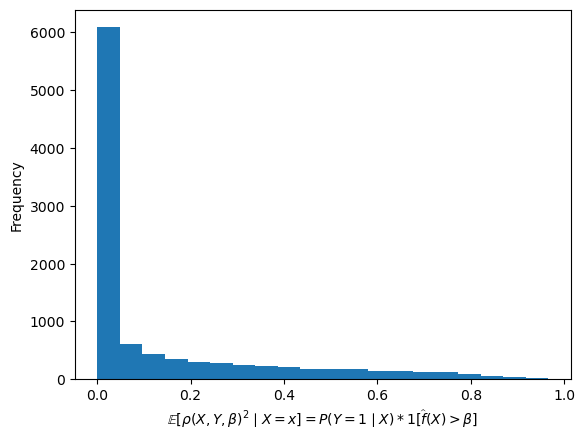

In [91]:
budget = 0.4
q_min = 0.1
single_beta = 0.2

fig, ax = plt.figure(), plt.gca()
rho_probs = (1 - expit(test_X.dot(true_coef) + true_bias)) * (learned_model.predict_proba(test_X)[:, 1] > single_beta)
probs = expit(test_X.dot(true_coef) + true_bias)
ax.hist(rho_probs, bins=20)
ax.set_xlabel('$\\mathbb{E}[\\rho(X, Y, \\beta)^2 \mid X = x] = P(Y = 1 \mid X) * 1[\widehat{f}(X) > \\beta]$')
ax.set_ylabel('Frequency')
print('Count of samples in each bin', feature_fn(test_X).sum(axis=0))


means, counts = [], []
for i in np.arange(0.1, 1.1, 0.1):
    mask = (probs >= i - 0.1) & (probs < i)
    means.append(np.mean(rho_probs[mask]))
    counts.append(np.sum(mask))
means, counts = np.array(means), np.array(counts)
bin_p_weights = counts / np.sum(counts)
bin_q_weights = np.sqrt(means)
approx_normalizer = np.sum(bin_p_weights * bin_q_weights)
approx_best_bin_probs = np.minimum(bin_q_weights / approx_normalizer * budget, 1.)
print('Optimal q for each feature', approx_best_bin_probs)
# print('Optimal q for each feature', compute_optimal_bin_q(rho_probs))

In [92]:
test_beta = single_beta
rng = np.random.default_rng(seed=322)

def true_prob_fn(x):
    return 

test_features = bin_features(test_X, true_coef, true_bias, d=10)#, score_fn=lambda x: learned_model.predict_proba(x)[:, 1], \
                             #beta=test_beta, d=10)
lr_model = LogisticRegressor(in_features=d, out_features=1)

def rho(x, beta):
    feature, (score, y) = x
    if y is None:
        return 0
    else:
        return (score >= beta) * (1 - y)

#lam_max = q_min / 2
lam_max = 0.5 * (1 / (1 / q_min - theta))
lam_list = [lam_max]
xisum, xisum_sq = (0, 0)
theta = 0.6

def oracle_obj_fn(x, pred):
    feature, (score, y) = x
    loss = rho(x, test_beta)
    no_pred = (1 - pred) * torch.log1p(lam_list[-1] * (theta - torch.tensor(0.)))
    xi = (theta - loss / pred)
    is_pred = pred * torch.log1p(lam_list[-1] * xi)
    wealth = no_pred + is_pred
    return wealth

def obj_fn(x, pred):
    feature, (score, y) = x
    loss = rho(x, test_beta)
    wealth = torch.log1p(lam_list[-1] * (theta - loss / pred))
    
    return wealth.detach() * torch.log(pred) + wealth
    #return wealth
def cons_fn(x, pred):
    return budget - pred
    
def opt_fn(x):
    opt = torch.optim.Adagrad(x, lr=.001)
    # scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t: 1)
    class NewOpt:
        def step(self, **kwargs):
            opt.step(**kwargs)
            scheduler.step()
        def zero_grad(self):
            opt.zero_grad()
    # return NewOpt()
    # return torch.optim.Adagrad(x, lr=lr_init)
    return opt
primal_player = OnlineLogisticRegression(regressor=lr_model, obj_fn=oracle_obj_fn, cons_fn=cons_fn, opt_fn=opt_fn)
max_dual = 0.5
dual_player = BestResponse(max_dual=max_dual)
#dual_player = BeTheLeader(max_dual=max_dual)

omm = OnlineMinimax(primal_player=primal_player, dual_player=dual_player)
qs = []
dual_vars = []
bin_probs = []
for x, score, y in zip(test_features, learned_prob[:, 1], test_Y):
    torch_x = torch.tensor(x).float()
    q = lr_model(torch_x)
    qs.append(q.item())
    try:
        did_label = rng.binomial(1, q.detach().numpy())
    except:
        pass
        # print(q.data, lam_list[-10:])
    if did_label:
        dv = omm.addobs((torch_x, (score, y)))
    else:
        # dv = omm.addobs((torch_x, (score, y)))

        dv = omm.addobs((torch_x, (score, None)))
    dual_vars.append(dv)
    xi = theta - (rho((torch_x, (score, y)), test_beta) / q)
    xisum += xi.detach()
    xisum_sq += torch.square(xi).detach()
    lam_list.append(np.clip(xisum / (xisum + xisum_sq), 0, lam_max))
    # bin_probs.append(get_bin_probs(lr_model).copy())

How well did our online learner learn the correct probability weights?
Probs under each bin [0.687985360622406, 0.6966055035591125, 0.695252537727356, 0.6953371167182922, 0.6674718856811523, 0.6136670708656311, 0.5907421112060547, 0.6783336997032166, 0.6491889357566833, 0.6340725421905518]
Approx correct probs [0.12254413 0.38397745 0.63934154 0.72490314 0.74729981 0.75319951
 0.70347863 0.61048291 0.48053455 0.2515518 ]
MAE: 0.19146691135165178


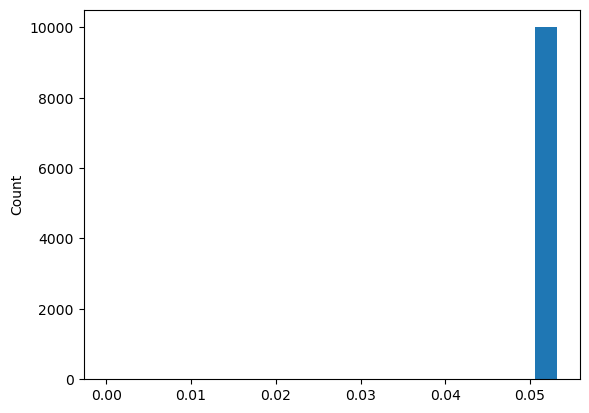

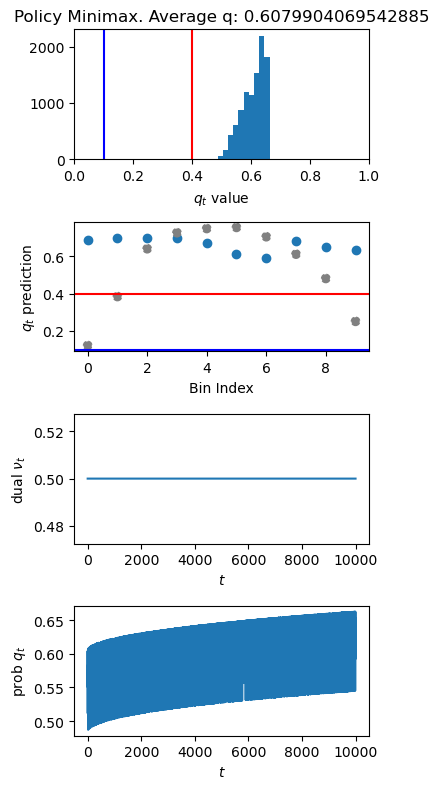

In [93]:
get_bin_probs(lr_model)
fig, ax = plt.figure(), plt.gca()
ax.hist(np.array([lam_list[0]] + [x.item() for x in lam_list[1:]]), bins=20)

debug_policy('Minimax', q_min, qs, budget, dual_vars, approx_best_bin_probs, model_bin_probs=get_bin_probs(lr_model))#, avg_bin_probs=avg_bin_probs)